# Import necessary libraries

In [473]:

import numpy as np
import torch
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import acf
from torch import nn

from src.classes.data.DataPreprocessor import DataPreprocessor
from src.functions.utils import load_data
from src.settings import APPLY_PCA

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Loading

In [474]:
x, y = load_data(path_to_data="../dataset.csv")

INFO: Loading dataset...

INFO: Dataset loaded successfully.

# Periodicity Detection

In [475]:
def detect_periodicity_acf(series, lag_limit=50):
    autocorr = acf(series, nlags=lag_limit, fft=True)
    peaks, _ = find_peaks(autocorr[1:])  # Exclude lag 0
    return len(peaks) > 0

In [476]:
idx_periodic = []
idx_non_periodic = []

x_num = x[x.select_dtypes(include=['float64', 'int64']).columns.tolist()]
for column in x_num.columns[:-1]:
    series = x_num[column].values
    if detect_periodicity_acf(series):
        idx_periodic.append(x_num.columns.get_loc(column))
    else:
        idx_non_periodic.append(x_num.columns.get_loc(column))

/Users/matteorizzo/PycharmProjects/brewery-ml/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


In [477]:
idx_num = [x.columns.get_loc(col) for col in x.select_dtypes(include=['float64', 'int64']).columns.tolist()]
idx_cat = [x.columns.get_loc(col) for col in x.select_dtypes(include=['object', 'category']).columns.tolist()]

data_preprocessor = DataPreprocessor(x, y, apply_pca=APPLY_PCA)
preprocessor = data_preprocessor.preprocess()
x = preprocessor.fit_transform(x)

# Split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

x_train_num, x_train_cat = x_train[:, idx_num], x_train[:, idx_cat]
x_val_num, x_val_cat = x_val[:, idx_num], x_val[:, idx_cat]
x_test_num, x_test_cat = x_test[:, idx_num], x_test[:, idx_cat]

x_train_num_p, x_train_num_np = x_train_num[:, idx_periodic], x_train[:, idx_non_periodic]
x_val_num_p, x_val_num_np = x_val[:, idx_periodic], x_val[:, idx_non_periodic]
x_test_num_p, x_test_num_np = x_test[:, idx_periodic], x_test[:, idx_non_periodic]

x_train_num_p_tsr = torch.tensor(x_train_num_p, dtype=torch.float32).to(device)
x_train_num_np_tsr = torch.tensor(x_train_num_np, dtype=torch.float32).to(device)
x_val_num_p_tsr = torch.tensor(x_val_num_p, dtype=torch.float32).to(device)
x_val_num_np_tsr = torch.tensor(x_val_num_np, dtype=torch.float32).to(device)
x_test_num_p_tsr = torch.tensor(x_test_num_p, dtype=torch.float32).to(device)
x_test_num_np_tsr = torch.tensor(x_test_num_np, dtype=torch.float32).to(device)

x_train_cat_tsr = torch.tensor(x_train_cat, dtype=torch.float32).to(device)
x_val_cat_tsr = torch.tensor(x_val_cat, dtype=torch.float32).to(device)
x_test_cat_tsr = torch.tensor(x_test_cat, dtype=torch.float32).to(device)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

INFO: DataPreprocessor initialized with 23 numerical and 4 categorical columns.

INFO: Starting data preprocessing: Scaling numerical and encoding categorical features...

INFO: Data preprocessing complete.

# Networks

In [478]:
class LearnableFourierLayer(nn.Module):
    def __init__(self, input_size, num_features_per_input, scale=True, init_frequency_range=(1.0, 10.0)):
        """
        Optimized Learnable Fourier Transform Layer with per-feature transformations.
        
        :param input_size: Number of input features.
        :param num_features_per_input: Number of Fourier features per input feature.
        :param scale: Whether to scale the input before applying the Fourier Transform.
        :param init_frequency_range: Range for the initialization of the frequency matrix B.
        """
        super(LearnableFourierLayer, self).__init__()
        self.scale = scale
        self.input_size = input_size
        self.num_features_per_input = num_features_per_input

        # Per-feature frequency parameters
        self.B = nn.Parameter(torch.empty(input_size, num_features_per_input))
        nn.init.uniform_(self.B, *init_frequency_range)

        if self.scale:
            self.scale_param = nn.Parameter(torch.ones(input_size))  # Per-feature scaling

    def forward(self, x):
        if self.scale:
            x = x * self.scale_param  # Shape: [batch_size, input_size]

        x = x.unsqueeze(2)  # Shape: [batch_size, input_size, 1]
        B = self.B.unsqueeze(0)  # Shape: [1, input_size, num_features_per_input]
        x_proj = 2 * np.pi * x * B  # Shape: [batch_size, input_size, num_features_per_input]

        # Compute sin and cos
        x_sin = torch.sin(x_proj)
        x_cos = torch.cos(x_proj)

        # Concatenate and flatten
        x_fourier = torch.cat([x_sin, x_cos], dim=2)  # Shape: [batch_size, input_size, num_features_per_input * 2]
        x_fourier = x_fourier.view(x.size(0), -1)  # Shape: [batch_size, total_fourier_features]
        return x_fourier


class FourierNet(nn.Module):
    def __init__(self, input_size, num_fourier_features, hidden_size, num_layers=3, dropout_prob=0.2, batch_norm=True):
        """
        Improved FourierNet with flexible number of layers, regularization, and learning rate scheduling.
        
        :param input_size: Size of the input features.
        :param num_fourier_features: Number of Fourier features to learn.
        :param hidden_size: Size of hidden layers.
        :param num_layers: Number of hidden layers.
        :param dropout_prob: Dropout probability for regularization.
        :param batch_norm: Whether to use batch normalization.
        """
        super(FourierNet, self).__init__()
        self.fourier_layer = LearnableFourierLayer(input_size, num_fourier_features)

        total_features = num_fourier_features * 2  # We have sine and cosine outputs

        # Fully Connected Layers with flexible depth
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Linear(total_features, hidden_size))
            if batch_norm:
                layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.SiLU())
            layers.append(nn.Dropout(dropout_prob))
            total_features = hidden_size  # After the first layer, total_features = hidden_size

        # Output Layer
        layers.append(nn.Linear(hidden_size, 1))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        # Apply Fourier transformation to input features
        x_fourier = self.fourier_layer(x)
        # Feed Fourier-transformed features into fully connected layers
        return self.network(x_fourier)


# TabFourierNet that supports both continuous and categorical features
class TabFourierNet(nn.Module):
    def __init__(self, continuous_input_size, categorical_input_size, num_fourier_features, hidden_size,
                 num_layers=3, dropout_prob=0.2, batch_norm=True):
        super(TabFourierNet, self).__init__()

        self.continuous_input_size = continuous_input_size
        self.categorical_input_size = categorical_input_size

        # Fourier layer for continuous features
        self.fourier_layer = LearnableFourierLayer(continuous_input_size, num_fourier_features)

        # MLP for one-hot encoded categorical features
        self.categorical_mlp = nn.Sequential(
            nn.Linear(categorical_input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
        )

        # Adjust total features
        total_continuous_features = continuous_input_size * num_fourier_features * 2
        total_features = total_continuous_features + hidden_size  # Output size of categorical MLP

        # Fully connected layers
        layers = []
        input_size = total_features
        for _ in range(num_layers):
            layers.append(nn.Linear(input_size, hidden_size))
            if batch_norm:
                layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.SiLU())
            layers.append(nn.Dropout(dropout_prob))
            input_size = hidden_size

        # Output Layer
        layers.append(nn.Linear(hidden_size, 1))

        self.network = nn.Sequential(*layers)

    def forward(self, x_continuous, x_categorical_onehot):
        # Fourier transform continuous features
        x_fourier = self.fourier_layer(x_continuous)

        # Process one-hot encoded categorical features through MLP
        x_categorical_processed = self.categorical_mlp(x_categorical_onehot)

        # Combine features
        x_combined = torch.cat([x_fourier, x_categorical_processed], dim=1)

        # Pass through fully connected layers
        return self.network(x_combined)



In [479]:
class ChebyshevLayer(nn.Module):
    def __init__(self, input_size, num_terms, scale=True, normalize=True):
        """
        Optimized Chebyshev Polynomial Layer with vectorized computations.
        
        :param input_size: Number of input features.
        :param num_terms: Number of Chebyshev polynomial terms.
        :param scale: Whether to scale the input for stability.
        :param normalize: Whether to normalize the Chebyshev terms.
        """
        super(ChebyshevLayer, self).__init__()
        self.num_terms = num_terms
        self.scale = scale
        self.normalize = normalize

        if self.scale:
            self.scale_param = nn.Parameter(torch.ones(input_size))  # Per-feature scaling

        if self.normalize:
            self.norm_layer = nn.LayerNorm(input_size * num_terms)

    def forward(self, x):
        if self.scale:
            x = x * self.scale_param

        x = x.unsqueeze(2)  # Shape: [batch_size, input_size, 1]
        T = [torch.ones_like(x), x]  # T0 and T1

        for _ in range(2, self.num_terms):
            T_next = 2 * x * T[-1] - T[-2]
            T.append(T_next)

        x_cheb = torch.cat(T, dim=2)  # Shape: [batch_size, input_size, num_terms]
        x_cheb = x_cheb.view(x.size(0), -1)  # Flatten

        if self.normalize:
            x_cheb = self.norm_layer(x_cheb)

        return x_cheb


class ChebyshevNet(nn.Module):
    def __init__(self, input_size, num_chebyshev_terms, hidden_size, num_layers=3, dropout_prob=0.2, batch_norm=True):
        """
        Improved ChebyshevNet with flexible number of layers, regularization, and learning rate scheduling.
        
        :param input_size: Size of the input features.
        :param num_chebyshev_terms: Number of Chebyshev polynomial terms.
        :param hidden_size: Size of hidden layers.
        :param num_layers: Number of hidden layers (flexible).
        :param dropout_prob: Dropout probability for regularization.
        :param batch_norm: Whether to use batch normalization.
        """
        super(ChebyshevNet, self).__init__()
        self.chebyshev_layer = ChebyshevLayer(input_size, num_chebyshev_terms, normalize=True)

        total_features = input_size * num_chebyshev_terms  # Number of Chebyshev terms

        # Fully Connected Layers
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Linear(total_features, hidden_size))
            if batch_norm:
                layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.SiLU())
            layers.append(nn.Dropout(dropout_prob))
            total_features = hidden_size  # Hidden layer size remains constant after the first layer

        # Output Layer
        layers.append(nn.Linear(hidden_size, 1))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        # Apply Chebyshev transformation
        x_chebyshev = self.chebyshev_layer(x)
        # Feed into fully connected layers
        return self.network(x_chebyshev)


class TabChebyshevNet(nn.Module):
    def __init__(self, continuous_input_size, categorical_input_size, num_chebyshev_terms,
                 hidden_size, num_layers=3, dropout_prob=0.2, batch_norm=True):
        """
        TabChebyshevNet that accepts one-hot encoded categorical features.

        :param continuous_input_size: Number of continuous input features.
        :param categorical_input_size: Total number of one-hot encoded categorical features.
        :param num_chebyshev_terms: Number of Chebyshev polynomial terms.
        :param hidden_size: Size of hidden layers.
        :param num_layers: Number of hidden layers.
        :param dropout_prob: Dropout probability for regularization.
        :param batch_norm: Whether to use batch normalization.
        """
        super(TabChebyshevNet, self).__init__()

        self.continuous_input_size = continuous_input_size
        self.categorical_input_size = categorical_input_size

        # Chebyshev Layer for continuous features
        self.chebyshev_layer = ChebyshevLayer(continuous_input_size, num_chebyshev_terms, normalize=True)

        total_continuous_features = continuous_input_size * num_chebyshev_terms
        total_categorical_features = categorical_input_size  # One-hot encoded features

        total_features = total_continuous_features + total_categorical_features

        # Optionally, process categorical features through an MLP
        self.categorical_mlp = nn.Sequential(
            nn.Linear(categorical_input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
        )

        # Adjust total features if using MLP for categorical features
        total_categorical_features = hidden_size

        total_features = total_continuous_features + total_categorical_features

        # Fully Connected Layers with flexible depth
        layers = []
        input_size = total_features
        for _ in range(num_layers):
            layers.append(nn.Linear(input_size, hidden_size))
            if batch_norm:
                layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.SiLU())
            layers.append(nn.Dropout(dropout_prob))
            input_size = hidden_size  # Hidden layer size remains constant after the first layer

        # Output Layer
        layers.append(nn.Linear(hidden_size, 1))

        self.network = nn.Sequential(*layers)

    def forward(self, x_continuous, x_categorical):
        """
        Forward pass of the network.

        :param x_continuous: Tensor of continuous features, shape [batch_size, continuous_input_size].
        :param x_categorical: Tensor of one-hot encoded categorical features, shape [batch_size, categorical_input_size].
        """
        # Apply Chebyshev transformation to continuous features
        x_chebyshev = self.chebyshev_layer(x_continuous)  # Shape: [batch_size, total_continuous_features]

        # Process one-hot encoded categorical features through MLP
        x_categorical_processed = self.categorical_mlp(x_categorical)  # Shape: [batch_size, hidden_size]

        # Combine features
        x_combined = torch.cat([x_chebyshev, x_categorical_processed], dim=1)  # Shape: [batch_size, total_features]

        # Feed combined features into fully connected layers
        return self.network(x_combined)


In [480]:
class PNPNet(nn.Module):
    def __init__(self, periodic_input_size, non_periodic_input_size, num_fourier_features, num_chebyshev_terms,
                 hidden_size, dropout_prob=0.2, batch_norm=True):
        """
        A combined neural network that integrates Fourier and Chebyshev layers.
        
        :param periodic_input_size: Size of periodic input features.
        :param non_periodic_input_size: Size of non-periodic input features.
        :param num_fourier_features: Number of Fourier features to learn.
        :param num_chebyshev_terms: Number of Chebyshev terms.
        :param hidden_size: Number of neurons in hidden layers.
        :param dropout_prob: Dropout probability for regularization.
        :param batch_norm: Whether to use batch normalization.
        """
        super(PNPNet, self).__init__()
        self.fourier_layer = LearnableFourierLayer(periodic_input_size, num_fourier_features)
        self.chebyshev_layer = ChebyshevLayer(non_periodic_input_size, num_chebyshev_terms)

        total_features = (num_fourier_features * 2) + (non_periodic_input_size * num_chebyshev_terms)

        # Build the network with batch normalization and dropout options
        layers = [nn.Linear(total_features, hidden_size)]
        if batch_norm:
            layers.append(nn.BatchNorm1d(hidden_size))  # Batch normalization
        layers.append(nn.SiLU())
        layers.append(nn.Dropout(dropout_prob))

        # Additional hidden layers
        layers.append(nn.Linear(hidden_size, hidden_size))
        if batch_norm:
            layers.append(nn.BatchNorm1d(hidden_size))
        layers.append(nn.SiLU())
        layers.append(nn.Dropout(dropout_prob))

        # Output layer
        layers.append(nn.Linear(hidden_size, 1))

        self.network = nn.Sequential(*layers)

    def forward(self, x_periodic, x_non_periodic):
        # Apply Fourier and Chebyshev layers
        x_fourier = self.fourier_layer(x_periodic)
        x_chebyshev = self.chebyshev_layer(x_non_periodic)

        # Concatenate Fourier and Chebyshev outputs
        x_combined = torch.cat([x_fourier, x_chebyshev], dim=-1)

        # Feed the combined features into the fully connected layers
        return self.network(x_combined)

In [481]:
# Periodicity-Based Feature Selector (modified)
class PeriodicityFeatureSelector(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        """
        Enhanced PeriodicityFeatureSelector with additional layers and an attention mechanism.
        
        :param input_size: Number of input features.
        :param hidden_size: Number of neurons in the hidden layers.
        :param num_layers: Number of hidden layers.
        """
        super(PeriodicityFeatureSelector, self).__init__()
        layers = []
        in_features = input_size
        for _ in range(num_layers):
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())
            in_features = hidden_size
        layers.append(nn.Linear(hidden_size, input_size))
        layers.append(nn.Sigmoid())  # Produces periodicity scores between 0 and 1
        self.periodicity_estimator = nn.Sequential(*layers)

    def forward(self, x):
        # Estimate the periodicity of each input feature
        periodicity_scores = self.periodicity_estimator(x)  # Shape: [batch_size, input_size]
        return periodicity_scores


class AttentionPeriodicityFeatureSelector(nn.Module):
    def __init__(self, input_size, embed_size=64, num_heads=4):
        """
        Attention-based PeriodicityFeatureSelector using self-attention over features.

        :param input_size: Number of input features.
        :param embed_size: Embedding size for attention computations.
        :param num_heads: Number of attention heads.
        """
        super(AttentionPeriodicityFeatureSelector, self).__init__()
        self.embed_size = embed_size
        self.input_size = input_size
        self.num_heads = num_heads

        # Linear projection to embedding space
        self.embedding = nn.Linear(1, embed_size)

        # MultiheadAttention with batch_first=True to accept inputs as [batch_size, seq_length, embed_dim]
        self.attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=num_heads, batch_first=True)

        # Output layer to map from embed_size back to 1
        self.fc = nn.Linear(embed_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: [batch_size, input_size]
        # Reshape x to [batch_size, input_size, 1], treating features as sequence elements
        x = x.unsqueeze(-1)  # Shape: [batch_size, input_size, 1]

        # Embed x
        x_embedded = self.embedding(x)  # Shape: [batch_size, input_size, embed_size]

        # Compute self-attention over features
        # Since features are treated as sequence elements, attention is over the feature dimension
        attn_output, attn_weights = self.attention(x_embedded, x_embedded,
                                                   x_embedded)  # Outputs have shape [batch_size, input_size, embed_size]

        # Pass through output layer to get a single value per feature
        out = self.fc(attn_output)  # Shape: [batch_size, input_size, 1]

        # Squeeze last dimension and apply sigmoid to get periodicity scores between 0 and 1
        periodicity_scores = self.sigmoid(out.squeeze(-1))  # Shape: [batch_size, input_size]

        return periodicity_scores


class AutoPNPNet(nn.Module):
    def __init__(self, input_size, num_fourier_features, num_chebyshev_terms, hidden_size, num_layers=3,
                 dropout_prob=0.2, batch_norm=True, activation='SiLU'):
        super(AutoPNPNet, self).__init__()

        self.input_size = input_size
        self.fourier_layer = LearnableFourierLayer(input_size, num_fourier_features)
        self.chebyshev_layer = ChebyshevLayer(input_size, num_chebyshev_terms)

        self.total_fourier_features = input_size * num_fourier_features * 2
        self.total_chebyshev_features = input_size * num_chebyshev_terms
        total_features = self.total_fourier_features + self.total_chebyshev_features

        self.feature_selector = PeriodicityFeatureSelector(input_size)

        activation_fn = self._get_activation_function(activation)

        # Fully Connected Layers
        layers = []
        for _ in range(num_layers):
            layers.extend([
                nn.Linear(total_features, hidden_size),
                nn.BatchNorm1d(hidden_size) if batch_norm else nn.Identity(),
                activation_fn,
                nn.Dropout(dropout_prob)
            ])
            total_features = hidden_size

        # Output Layer
        layers.append(nn.Linear(hidden_size, 1))
        self.network = nn.Sequential(*layers)

        # Residual connection layer
        self.residual_layer = nn.Linear(self.total_fourier_features + self.total_chebyshev_features, 1)

    @staticmethod
    def _get_activation_function(name):
        if name == 'ReLU':
            return nn.ReLU()
        elif name == 'SiLU':
            return nn.SiLU()
        elif name == 'LeakyReLU':
            return nn.LeakyReLU()
        else:
            raise ValueError(f"Unsupported activation function: {name}")

    def forward(self, x):
        batch_size = x.size(0)
        # Estimate periodicity scores
        periodicity_scores = self.feature_selector(x)  # Shape: [batch_size, input_size]

        # Apply Fourier and Chebyshev transformations
        x_fourier = self.fourier_layer(x)  # Shape: [batch_size, total_fourier_features]
        x_chebyshev = self.chebyshev_layer(x)  # Shape: [batch_size, total_chebyshev_features]

        # Reshape periodicity scores for gating
        num_fourier_features_per_input = self.fourier_layer.num_features_per_input * 2
        num_chebyshev_features_per_input = self.chebyshev_layer.num_terms

        # Gating for Fourier features
        periodicity_scores_fourier = periodicity_scores.unsqueeze(2).repeat(1, 1, num_fourier_features_per_input)
        periodicity_scores_fourier = periodicity_scores_fourier.view(batch_size, -1)

        # Gating for Chebyshev features
        periodicity_scores_chebyshev = (1 - periodicity_scores).unsqueeze(2).repeat(1, 1,
                                                                                    num_chebyshev_features_per_input)
        periodicity_scores_chebyshev = periodicity_scores_chebyshev.view(batch_size, -1)

        # Apply gating
        x_fourier_weighted = x_fourier * periodicity_scores_fourier
        x_chebyshev_weighted = x_chebyshev * periodicity_scores_chebyshev

        # Combine features
        x_combined = torch.cat([x_fourier_weighted, x_chebyshev_weighted], dim=1)

        # Residual connection
        residual = self.residual_layer(x_combined)

        # Pass through fully connected layers
        out = self.network(x_combined)

        # Add residual
        out += residual

        return out
    

class TabAutoPNPNet(nn.Module):
    def __init__(self, continuous_input_size, categorical_input_size,
                 num_fourier_features_per_input, num_chebyshev_terms, hidden_size, num_layers=3,
                 dropout_prob=0.2, batch_norm=True, activation='SiLU'):
        """
        TabAutoPNPNet: Extends AutoPNPNet to support both continuous and one-hot encoded categorical features.

        :param continuous_input_size: Number of continuous input features.
        :param categorical_input_size: Total number of one-hot encoded categorical features.
        :param num_fourier_features_per_input: Number of Fourier features per continuous input feature.
        :param num_chebyshev_terms: Number of Chebyshev polynomial terms.
        :param hidden_size: Size of hidden layers.
        :param num_layers: Number of hidden layers.
        :param dropout_prob: Dropout probability for regularization.
        :param batch_norm: Whether to use batch normalization.
        :param activation: Activation function to use in hidden layers.
        """
        super(TabAutoPNPNet, self).__init__()

        self.continuous_input_size = continuous_input_size
        self.categorical_input_size = categorical_input_size

        # Fourier and Chebyshev layers for continuous features
        self.fourier_layer = LearnableFourierLayer(continuous_input_size, num_fourier_features_per_input)
        self.chebyshev_layer = ChebyshevLayer(continuous_input_size, num_chebyshev_terms)

        self.total_fourier_features = continuous_input_size * num_fourier_features_per_input * 2  # Times 2 for sin and cos
        self.total_chebyshev_features = continuous_input_size * num_chebyshev_terms

        # Periodicity-based feature selector for continuous features
        self.feature_selector = PeriodicityFeatureSelector(continuous_input_size)

        # MLP for one-hot encoded categorical features
        self.categorical_mlp = nn.Sequential(
            nn.Linear(categorical_input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
        )

        # Total features after combining continuous and categorical features
        total_features = self.total_fourier_features + self.total_chebyshev_features + hidden_size

        activation_fn = self._get_activation_function(activation)

        # Fully Connected Layers
        layers = []
        for _ in range(num_layers):
            layers.extend([
                nn.Linear(total_features, hidden_size),
                nn.BatchNorm1d(hidden_size) if batch_norm else nn.Identity(),
                activation_fn,
                nn.Dropout(dropout_prob)
            ])
            total_features = hidden_size

        # Output Layer
        layers.append(nn.Linear(hidden_size, 1))
        self.network = nn.Sequential(*layers)

        # Residual connection layer for continuous features
        self.residual_layer = nn.Linear(self.total_fourier_features + self.total_chebyshev_features, 1)

    @staticmethod
    def _get_activation_function(name):
        if name == 'ReLU':
            return nn.ReLU()
        elif name == 'SiLU':
            return nn.SiLU()
        elif name == 'LeakyReLU':
            return nn.LeakyReLU()
        else:
            raise ValueError(f"Unsupported activation function: {name}")

    def forward(self, x_continuous, x_categorical):
        batch_size = x_continuous.size(0)

        # Estimate periodicity scores for continuous features
        periodicity_scores = self.feature_selector(x_continuous)  # Shape: [batch_size, continuous_input_size]

        # Apply Fourier and Chebyshev transformations to continuous features
        x_fourier = self.fourier_layer(x_continuous)  # Shape: [batch_size, total_fourier_features]
        x_chebyshev = self.chebyshev_layer(x_continuous)  # Shape: [batch_size, total_chebyshev_features]

        # Reshape periodicity scores for gating
        num_fourier_features_per_input = self.fourier_layer.num_features_per_input * 2  # Times 2 for sin and cos
        num_chebyshev_features_per_input = self.chebyshev_layer.num_terms

        # Gating for Fourier features
        periodicity_scores_fourier = periodicity_scores.unsqueeze(2).repeat(1, 1, num_fourier_features_per_input)
        periodicity_scores_fourier = periodicity_scores_fourier.view(batch_size, -1)

        # Gating for Chebyshev features
        periodicity_scores_chebyshev = (1 - periodicity_scores).unsqueeze(2).repeat(1, 1,
                                                                                    num_chebyshev_features_per_input)
        periodicity_scores_chebyshev = periodicity_scores_chebyshev.view(batch_size, -1)

        # Apply gating
        x_fourier_weighted = x_fourier * periodicity_scores_fourier
        x_chebyshev_weighted = x_chebyshev * periodicity_scores_chebyshev

        # Combine continuous features
        x_continuous_combined = torch.cat([x_fourier_weighted, x_chebyshev_weighted], dim=1)

        # Residual connection for continuous features
        residual = self.residual_layer(x_continuous_combined)

        # Process one-hot encoded categorical features through MLP
        x_categorical_processed = self.categorical_mlp(x_categorical)  # Shape: [batch_size, hidden_size]

        # Combine continuous and categorical features
        x_combined = torch.cat([x_continuous_combined, x_categorical_processed], dim=1)

        # Pass through fully connected layers
        out = self.network(x_combined)

        # Add residual (only from continuous features)
        out += residual

        return out


# Training

In [482]:
# Model hyperparameters
num_periodic_input_size = x_train_num_p_tsr.shape[1]
num_non_periodic_input_size = x_train_num_np_tsr.shape[1]
cat_input_size = x_train_cat_tsr.shape[1]
num_fourier_features = 16
num_chebyshev_terms = 5
hidden_size = 32
dropout_prob = 0.2
batch_norm = True

In [483]:
model_type = "tabautopnpnet"

if model_type == "fnet":
    model = FourierNet(
        input_size=num_periodic_input_size + num_non_periodic_input_size,
        num_fourier_features=num_fourier_features,
        hidden_size=hidden_size,
        dropout_prob=dropout_prob,
        batch_norm=batch_norm
    )
elif model_type == "tabfnet":
    model = TabFourierNet(
        continuous_input_size=num_periodic_input_size + num_non_periodic_input_size,
        categorical_input_size=cat_input_size,
        num_fourier_features=num_fourier_features,
        hidden_size=hidden_size,
        dropout_prob=dropout_prob,
        batch_norm=True
    )
elif model_type == "cnet":
    model = ChebyshevNet(
        input_size=num_periodic_input_size + num_non_periodic_input_size,
        num_chebyshev_terms=num_chebyshev_terms,
        hidden_size=hidden_size,
        dropout_prob=dropout_prob,
        batch_norm=batch_norm
    )
elif model_type == "tabcnet":
    model = TabChebyshevNet(
        continuous_input_size=num_periodic_input_size + num_non_periodic_input_size,
        categorical_input_size=cat_input_size,
        num_chebyshev_terms=num_chebyshev_terms,
        hidden_size=hidden_size,
        dropout_prob=dropout_prob,
        batch_norm=True
    )
elif model_type == "pnpnet":
    model = PNPNet(
        periodic_input_size=num_periodic_input_size,
        non_periodic_input_size=num_non_periodic_input_size,
        num_fourier_features=num_fourier_features,
        num_chebyshev_terms=num_chebyshev_terms,
        hidden_size=hidden_size,
        dropout_prob=dropout_prob,
        batch_norm=batch_norm
    )
elif model_type == "autopnpnet":
    model = AutoPNPNet(
        input_size=num_periodic_input_size + num_non_periodic_input_size,
        num_fourier_features=num_fourier_features,
        num_chebyshev_terms=num_chebyshev_terms,
        hidden_size=hidden_size,
        dropout_prob=dropout_prob,
        batch_norm=batch_norm
    )
elif model_type == "tabautopnpnet":
    model = TabAutoPNPNet(
    continuous_input_size=num_periodic_input_size + num_non_periodic_input_size,
    categorical_input_size=cat_input_size,
    num_fourier_features_per_input=num_fourier_features,
    num_chebyshev_terms=num_chebyshev_terms,
    hidden_size=hidden_size,
    dropout_prob=dropout_prob,
    batch_norm=True
)
else:
    raise ValueError("Unsupported model type!")

Epoch [100/10000], Training Loss: 2.422570, Validation Loss: 3.477500
Epoch [200/10000], Training Loss: 1.169625, Validation Loss: 2.769573

 Early stopping at epoch 232, no improvement for 50 epochs.


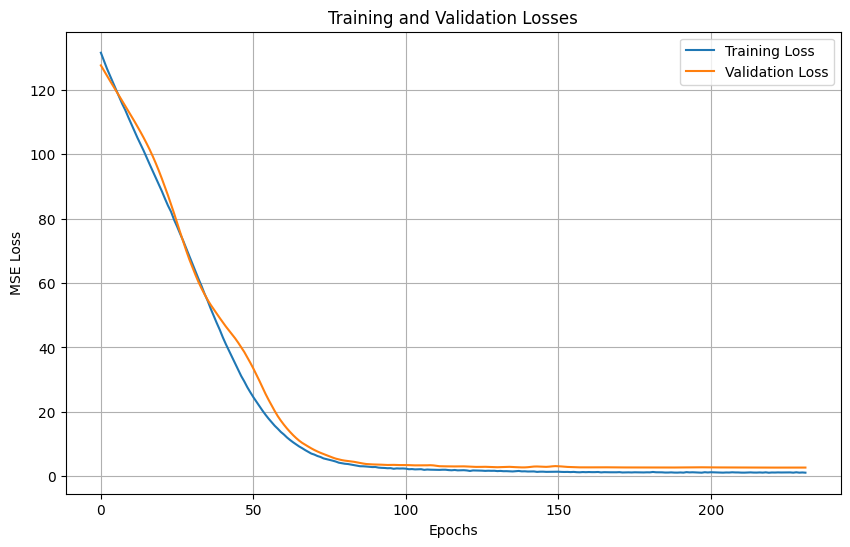

In [484]:
model = model.to(device)

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

# Early stopping parameters
early_stopping_patience = 50
best_val_loss = float('inf')
early_stopping_counter = 0
best_model_state = None

# Training parameters
epochs = 10000
print_every = 100
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass and loss calculation
    if model_type == "pnpnet":
        outputs = model(x_train_num_p_tsr, x_train_num_np_tsr)
    elif model_type.startswith("tab"):
        outputs = model(torch.cat([x_train_num_p_tsr, x_train_num_np_tsr], dim=-1), x_train_cat_tsr)
    else:
        outputs = model(x=torch.cat([x_train_num_p_tsr, x_train_num_np_tsr], dim=-1))
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Store training loss
    train_losses.append(loss.item())

    # Validation phase
    model.eval()
    with torch.no_grad():
        if model_type == "pnpnet":
            val_outputs = model(x_val_num_p_tsr, x_val_num_np_tsr)
        elif model_type.startswith("tab"):
            val_outputs = model(torch.cat([x_val_num_p_tsr, x_val_num_np_tsr], dim=-1), x_val_cat_tsr)
        else:
            val_outputs = model(x=torch.cat([x_val_num_p_tsr, x_val_num_np_tsr], dim=-1))
        val_loss = criterion(val_outputs, y_val_tensor)
        val_losses.append(val_loss.item())

    # Print progress every `print_every` epochs
    if (epoch + 1) % print_every == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {loss.item():.6f}, Validation Loss: {val_loss.item():.6f}')

    # Early stopping check
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save best model state
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print(f'\n Early stopping at epoch {epoch + 1}, no improvement for {early_stopping_patience} epochs.')
            break

    # Step the learning rate scheduler
    scheduler.step(val_loss)

# Load the best model after training
model.load_state_dict(best_model_state)

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()


# Test

Mean Squared Error on Test Set: 1.622827
R^2 Score on Test Set: 0.672723


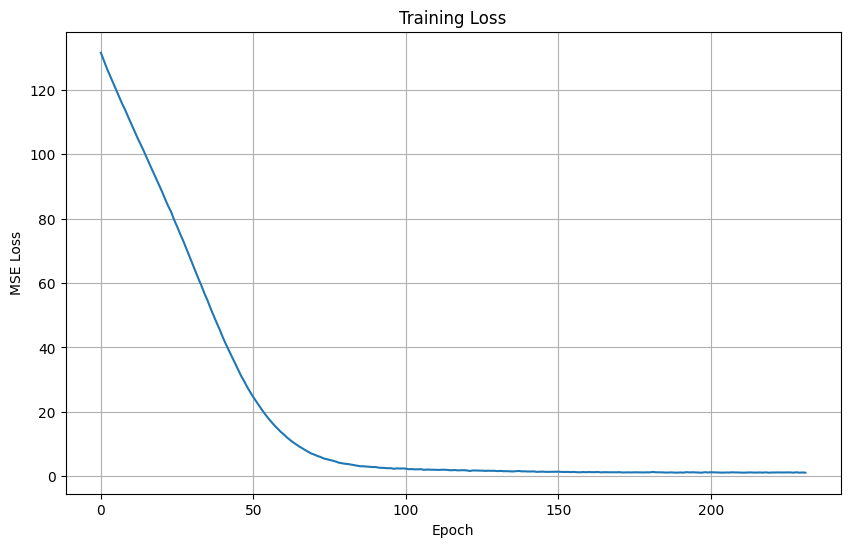

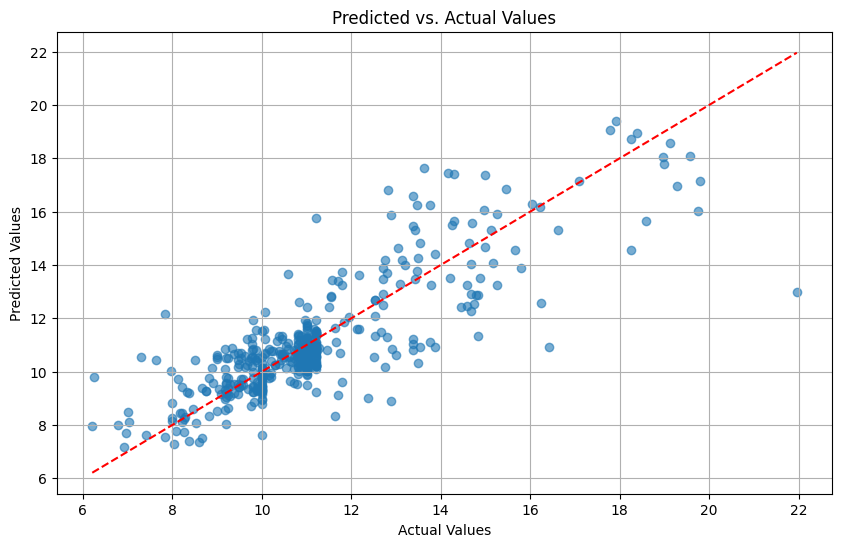

In [485]:
model.eval()
with torch.no_grad():
    if model_type == "pnpnet":
        predictions = model(x_test_num_p_tsr, x_test_num_np_tsr).squeeze().numpy()
    elif model_type.startswith("tab"):
        predictions = model(torch.cat([x_test_num_p_tsr, x_test_num_np_tsr], dim=-1), x_test_cat_tsr)
    else:
        predictions = model(x=torch.cat([x_test_num_p_tsr, x_test_num_np_tsr], dim=-1)).squeeze().numpy()
    actual = y_test_tensor.squeeze().numpy()

mse = mean_squared_error(actual, predictions)
r2 = r2_score(actual, predictions)

print(f'Mean Squared Error on Test Set: {mse:.6f}')
print(f'R^2 Score on Test Set: {r2:.6f}')

# 7. Visualization
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

# Plot predictions vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(actual, predictions, alpha=0.6)
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.grid(True)
plt.show()